In [1]:
import cell2cell as c2c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp

from cci_distance_correlation import get_correlation, get_correlation_plot

%matplotlib inline

# Analysis Setup

Here, all inputs and parameters needed for the analysis are defined

**Location of files**

In [2]:
data_folder = '../Data/'

In [3]:
files = dict()
files['rnaseq'] = data_folder + '/RNA-Seq/Celegans_RNASeqData_Cell.xlsx'
files['metadata'] = data_folder + '/RNA-Seq/Celegans_cell_metadata.tsv'
files['ppi'] = data_folder + '/PPI-Networks/Celegans-GA-Selected-LR-pairs.csv'
files['output_folder'] = '../Figures/'

**RNA-seq data manipulation**

- <font color="green">'gene_col'</font> is the name of the column containing the list or names of genes in the dataset.
- <font color="green">'drop_nangenes'</font> is a boolean decision to remove genes with NaN values.
- <font color="green">'log_transform'</font> is a boolean decision to log-transform the dataset.

In [4]:
rnaseq_setup = dict()
rnaseq_setup['gene_col'] = 'gene_id'
rnaseq_setup['drop_nangenes'] = True
rnaseq_setup['log_transform'] = False

**Metadata columns**

- <font color="green">'sample_col'</font> is the name of the column containing the sample or cell names in RNA-seq data (equivalent to the columns in rnaseq_data).
- <font color="green">'group_col'</font> is the name of the column containing the labels for the respective samples or cells in order to group/color them in downstream analyses.

In [5]:
meta_setup = dict()
meta_setup['sample_col'] = '#SampleID'
meta_setup['group_col'] = 'Groups'

**Columns for PPI network**

- <font color="green">'protein_cols'</font> is a list containing the names of the first and second interactors.

In [6]:
ppi_setup = dict()
ppi_setup['protein_cols'] = ['Ligand_WB', 'Receptor_WB']

**Cutoffs setup for binarizing gene expression**

- <font color="green">'type'</font> is the type of cutoff to use. 
    - 'constant_value'
    - 'local_percentile'
    - 'global_percentile'
    - None
- <font color="green">'parameter'</font> is the corresponding parameter for the type of cutoff. If percentile is used, it should be a value between 0 and 1. E.g. a value of 0.75 represents the 75-th percentile, and the cutoff to binarize the gene expression will be that value.

In [7]:
cutoff_setup = dict()
cutoff_setup['type'] = 'constant_value'
cutoff_setup['parameter'] = 10 # TPM

**General Analysis setups**

- <font color="green">'communication_score'</font> is the type of communication score used to detect active pathways between each pair of cell. It can be:
    - 'expression_thresholding'
    - 'expression_product'
    - 'expression_correlation'
    - 'differential_combinations'
- <font color="green">'cci_score'</font> is the scoring function to aggregate the communication scores. It can be:
    - 'bray_curtis'
    - 'jaccard'
    - 'count'
- <font color="green">'cci_type'</font> is the type of interaction between two cells. If it is undirected, ligand and receptor are considered from both cells. If it is directed, ligands from one cell and receptors from the other are considered separately with respect to ligands from the second cell and receptor from the first one. So, it can be:
    - 'undirected'
    - 'directed

In [8]:
analysis_setup = dict()
analysis_setup['communication_score'] = 'expression_thresholding'
analysis_setup['cci_score'] = 'bray_curtis' #'bray_curtis'
analysis_setup['cci_type'] = 'undirected'

# Load Data

**RNA-seq**

In [9]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file=files['rnaseq'],
                                 gene_column=rnaseq_setup['gene_col'],
                                 drop_nangenes=rnaseq_setup['drop_nangenes'],
                                 log_transformation=rnaseq_setup['log_transform'],
                                 format='auto')

Opening RNAseq datasets from ../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../Data//RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


**Metadata for cell types**

In [10]:
meta = c2c.io.load_metadata(metadata_file=files['metadata'],
                            rnaseq_data=rnaseq_data,
                            sample_col=meta_setup['sample_col'],
                            format='auto')

../Data//RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


**PPI network**

In [11]:
ppi_data = c2c.io.load_ppi(ppi_file=files['ppi'],
                           interaction_columns=ppi_setup['protein_cols'],
                           rnaseq_genes=list(rnaseq_data.index),
                           format='auto')

Opening PPI datasets from ../Data//PPI-Networks/Celegans-GA-Selected-LR-pairs.csv
../Data//PPI-Networks/Celegans-GA-Selected-LR-pairs.csv was correctly loaded
Removing bidirectionality of PPI network
Simplying PPI network


In [12]:
ppi_data.shape

(37, 3)

**Distance Matrix**

In [13]:
distance_mineuclidean = c2c.io.load_table(data_folder + '/Digital-3D-Map/Celegans_Physical_Distances_Min.csv',
                                          **{'index_col' : 0})

../Data//Digital-3D-Map/Celegans_Physical_Distances_Min.csv was correctly loaded


# Labels of LR pairs

In [14]:
lr_pairs = c2c.io.load_table(files['ppi'])

../Data//PPI-Networks/Celegans-GA-Selected-LR-pairs.csv was correctly loaded


In [15]:
lr_pairs.head()

,Ligand_WB,Receptor_WB,Ligand_symbol,Receptor_symbol,score,index,LR Function,L Function,R Function,Ligand_desc,Receptor_desc
0,WBGene00000903,WBGene00004860,daf-7,sma-6,1.0,1,TGF-B signaling,GDF11,BMPRIB,Is an ortholog of human GDF11 (growth differen...,Is an ortholog of human BMPR1A (bone morphogen...
1,WBGene00002881,WBGene00006894,let-756,ver-1,1.0,7,Canonical RTK-Ras-ERK signaling,FGF,fms-related tyrosine kinase 1,Is an ortholog of human FGF16 (fibroblast grow...,Is an ortholog of human FLT1 (fms related rece...
2,WBGene00000527,WBGene00001687,cle-1,gpn-1,1.0,13,Cell adhesion,Collagen,Glypican (co-receptor) Frizzled homolog,Is an ortholog of human COL15A1 (collagen type...,Is an ortholog of human GPC1 (glypican 1) and ...
3,WBGene00002280,WBGene00003930,let-2,pat-3,1.0,26,Cell adhesion,Collagen,Integrin,Is an ortholog of human COL4A5 (collagen type ...,Is an ortholog of human ITGB1 (integrin subuni...
4,WBGene00005648,WBGene00008779,srp-7,F14B4.1,1.0,28,Wnt signaling,Serpin family (Blocks wnt signaling),Wnt-Receptor,Is an ortholog of human SERPINB11 (serpin fami...,Is predicted to have Wnt-activated receptor ac...


In [16]:
labels_dict = dict()
for pair in lr_pairs.iterrows():
    original = (pair[1]['Ligand_WB'], pair[1]['Receptor_WB'])
    new = pair[1]['Ligand_symbol']+' / '+pair[1]['Receptor_symbol']
    labels_dict[original] = new 

# Run Analysis

### Cells to include

In [17]:
included_cells = sorted(list(set(rnaseq_data.columns) & set(distance_mineuclidean.columns)))

In [18]:
excluded_cells = sorted(list(set(rnaseq_data.columns) - set(included_cells)))

In [19]:
excluded_cells

['Distal_tip_cells',
 'Sex_myoblasts',
 'Socket_cells',
 'Vulval_precursors',
 'flp-1(+)_interneurons']

### Compute Cell-Cell Interactions

In [20]:
if analysis_setup['cci_type'] == 'undirected':
    bi_ppi_data = c2c.preprocessing.bidirectional_ppi_for_cci(ppi_data=ppi_data, verbose=False)
    ref_ppi = ppi_data
else:
    bi_ppi_data = ppi_data.copy()
    ref_ppi = None

interaction_space = c2c.core.InteractionSpace(rnaseq_data=rnaseq_data[included_cells],
                                              ppi_data=bi_ppi_data,
                                              gene_cutoffs=cutoff_setup,
                                              communication_score=analysis_setup['communication_score'],
                                              cci_score=analysis_setup['cci_score'],
                                              cci_type=analysis_setup['cci_type'],
                                              verbose=False)

# Compute interactions
interaction_space.compute_pairwise_cci_scores(use_ppi_score=False, verbose=False)

# Compute communication
interaction_space.compute_pairwise_communication_scores(ref_ppi_data=ref_ppi, cci_type='directed', verbose=False)

In [21]:
# Label LR pairs from WB to symbols
interaction_matrix = interaction_space.interaction_elements['communication_matrix']
interaction_matrix.index = interaction_matrix.index.map(labels_dict)

### Visualize CCI & CCC

In [22]:
# Colors from figure S14 in C elegans paper (cell type expression data)
colors = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
          'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
          'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
          'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
          'Intestine': (1.0, 1.0, 0.2), # Yellow
          'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
          'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
          'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

**CCIs**

Interaction space detected as an InteractionSpace class


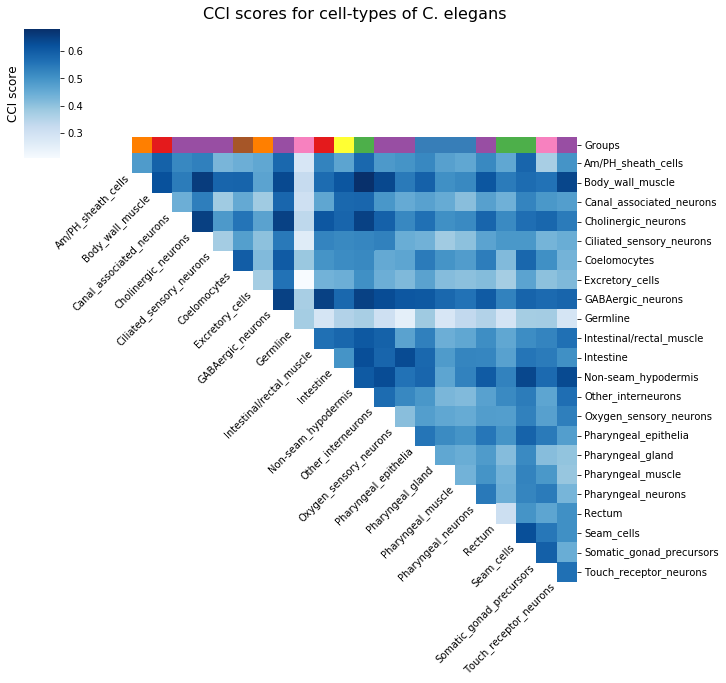

In [23]:
# Heatmap - No Clustering
hm = c2c.plotting.clustermap_cci(interaction_space,
                                 excluded_cells=excluded_cells,
                                 metadata=meta,
                                 sample_col=meta_setup['sample_col'],
                                 group_col=meta_setup['group_col'],
                                 colors=colors,
                                 title='CCI scores for cell-types of C. elegans',
                                 filename=files['output_folder'] + '/CCI-Heatmap-Celegans-SelectedLR.svg',
                                 **{'cmap' : 'Blues', 'row_cluster' : False, 'col_cluster' : False}
                                 )

Interaction space detected as an InteractionSpace class


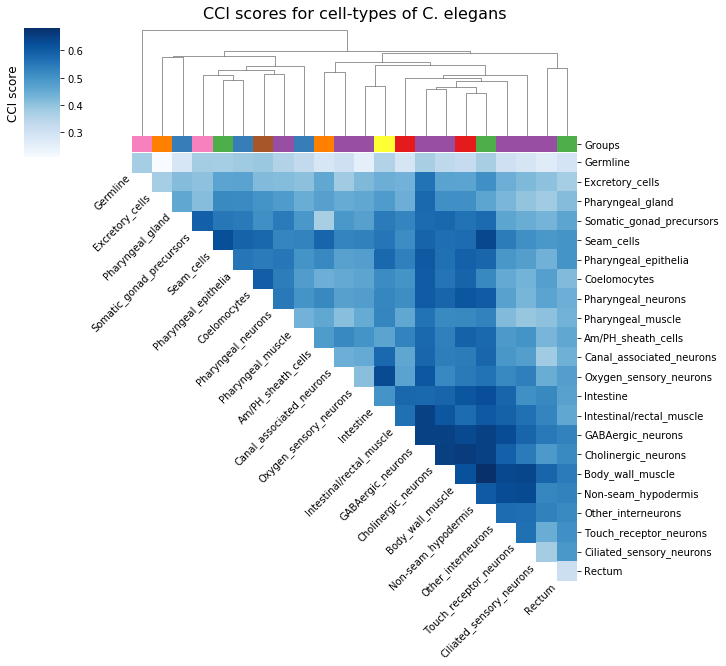

In [24]:
# Clustering
cm = c2c.plotting.clustermap_cci(interaction_space,
                                 method='complete',
                                 excluded_cells=excluded_cells,
                                 metadata=meta,
                                 sample_col=meta_setup['sample_col'],
                                 group_col=meta_setup['group_col'],
                                 colors=colors,
                                 title='CCI scores for cell-types of C. elegans',
                                 filename=files['output_folder'] + '/CCI-Clustermap-Celegans-SelectedLR.svg',
                                 **{'cmap' : 'Blues'}
                                 )

Interaction space detected as an InteractionSpace class


/Users/earmingol/Dropbox/Universidad/UCSanDiego/Lab_Lewis/cell2cell/cell2cell/external/pcoa.py:144: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.009340973458454685 and the largest is 0.41843645092263787.
  RuntimeWarning


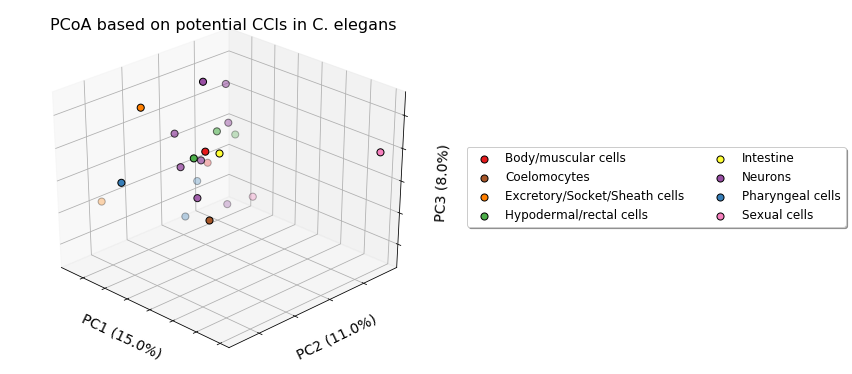

In [26]:
if (interaction_space.interaction_elements['cci_matrix'].values.transpose() == interaction_space.interaction_elements['cci_matrix'].values).all():
        
    pcoa = c2c.plotting.pcoa_3dplot(interaction_space,
                                    excluded_cells=excluded_cells,
                                    metadata=meta,
                                    sample_col=meta_setup['sample_col'],
                                    group_col=meta_setup['group_col'],
                                    title='PCoA based on potential CCIs in C. elegans',
                                    colors=colors,
                                    filename=files['output_folder'] + '/CCI-PCoA-CCI-scores-Celegans-SelectedLR.svg',
                                   )

**CCC**

Interaction space detected as an InteractionSpace class


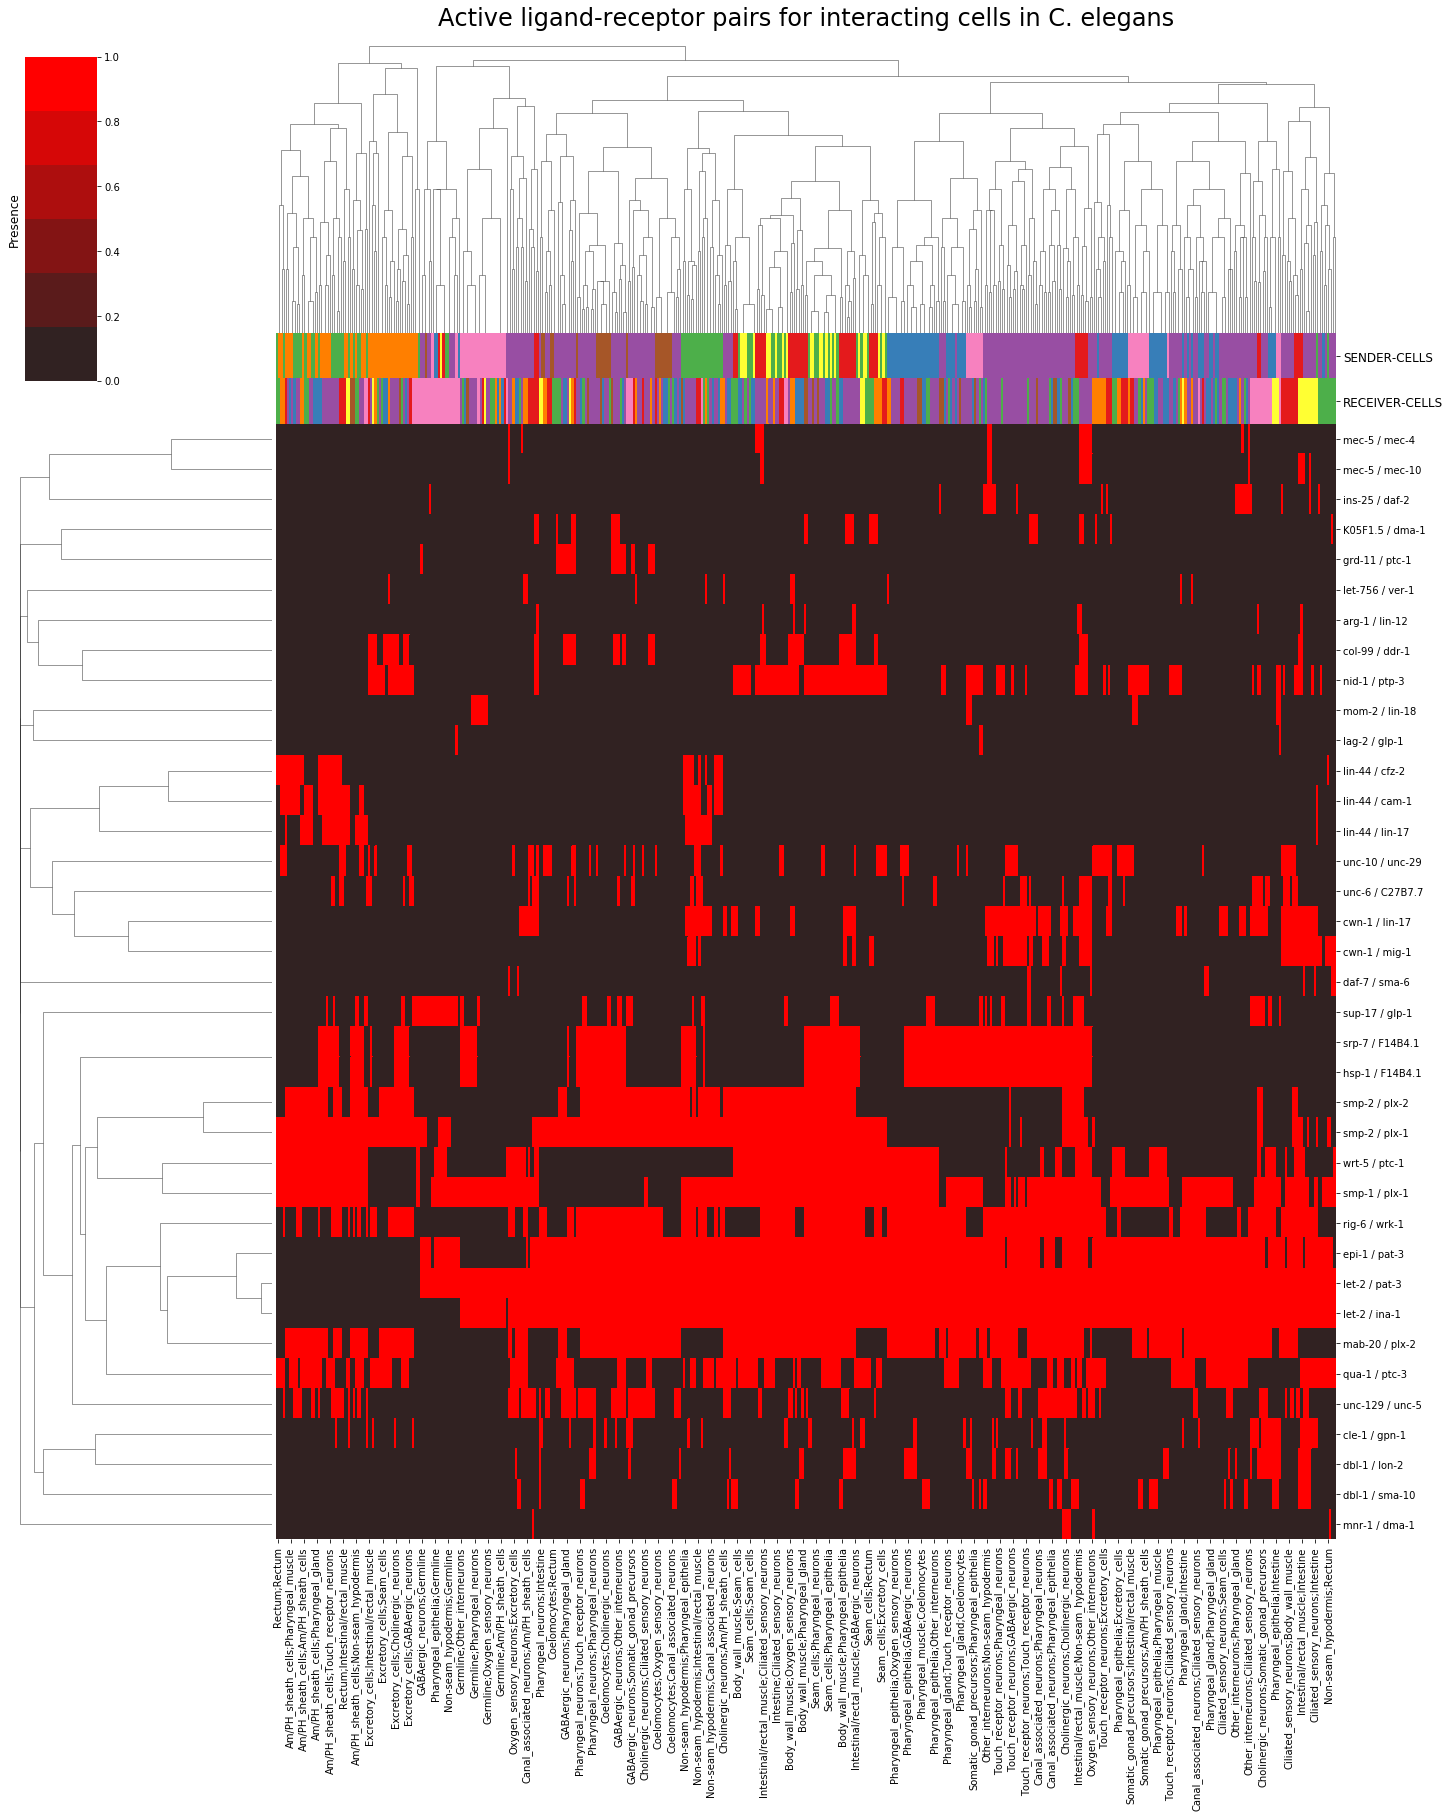

In [27]:
interaction_clustermap = c2c.plotting.clustermap_ccc(interaction_space,
                                                     metric='jaccard',
                                                     method='complete',
                                                     metadata=meta,
                                                     sample_col=meta_setup['sample_col'],
                                                     group_col=meta_setup['group_col'],
                                                     colors=colors,
                                                     excluded_cells=excluded_cells,
                                                     row_fontsize=12,
                                                     title='Active ligand-receptor pairs for interacting cells in C. elegans',
                                                     filename=files['output_folder'] + 'CCC-Celegans-SelectedLR.svg',
                                                     cell_labels=('SENDER-CELLS', 'RECEIVER-CELLS'),
                                                     **{'figsize' : (20,25)}
                                                     )

# Save Table
#interaction_clustermap.data2d.to_csv(files['output_folder'] + 'CCC-Celegans-SelectedLR.csv')

In [28]:
sorted_pairs = sorted(list(interaction_space.interaction_elements['communication_matrix'].columns))
interaction_space.interaction_elements['communication_matrix'][sorted_pairs].to_csv(files['output_folder'] + 'CCC-Celegans-SelectedLR.csv')

**Ligands and Receptors produced per cell types**

In [29]:
cell_labels = []
for group, df in meta.groupby(['type']):
    cell_labels += df.loc[~df['#SampleID'].isin(excluded_cells)] \
                     .sort_values(['#SampleID'])['#SampleID'].values.tolist()

In [30]:
col_colors = pd.DataFrame(cell_labels, columns=['Cell'])
col_colors['Cell Groups'] = col_colors['Cell'].apply(lambda x: colors[meta.loc[meta['#SampleID'] == x.split(';')[0], 'Groups'].values[0]])

col_colors.set_index('Cell', inplace=True)

In [31]:
genes_dict = dict(zip(lr_pairs['Ligand_WB'], lr_pairs['Ligand_symbol']))
genes_dict.update(dict(zip(lr_pairs['Receptor_WB'], lr_pairs['Receptor_symbol'])))

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


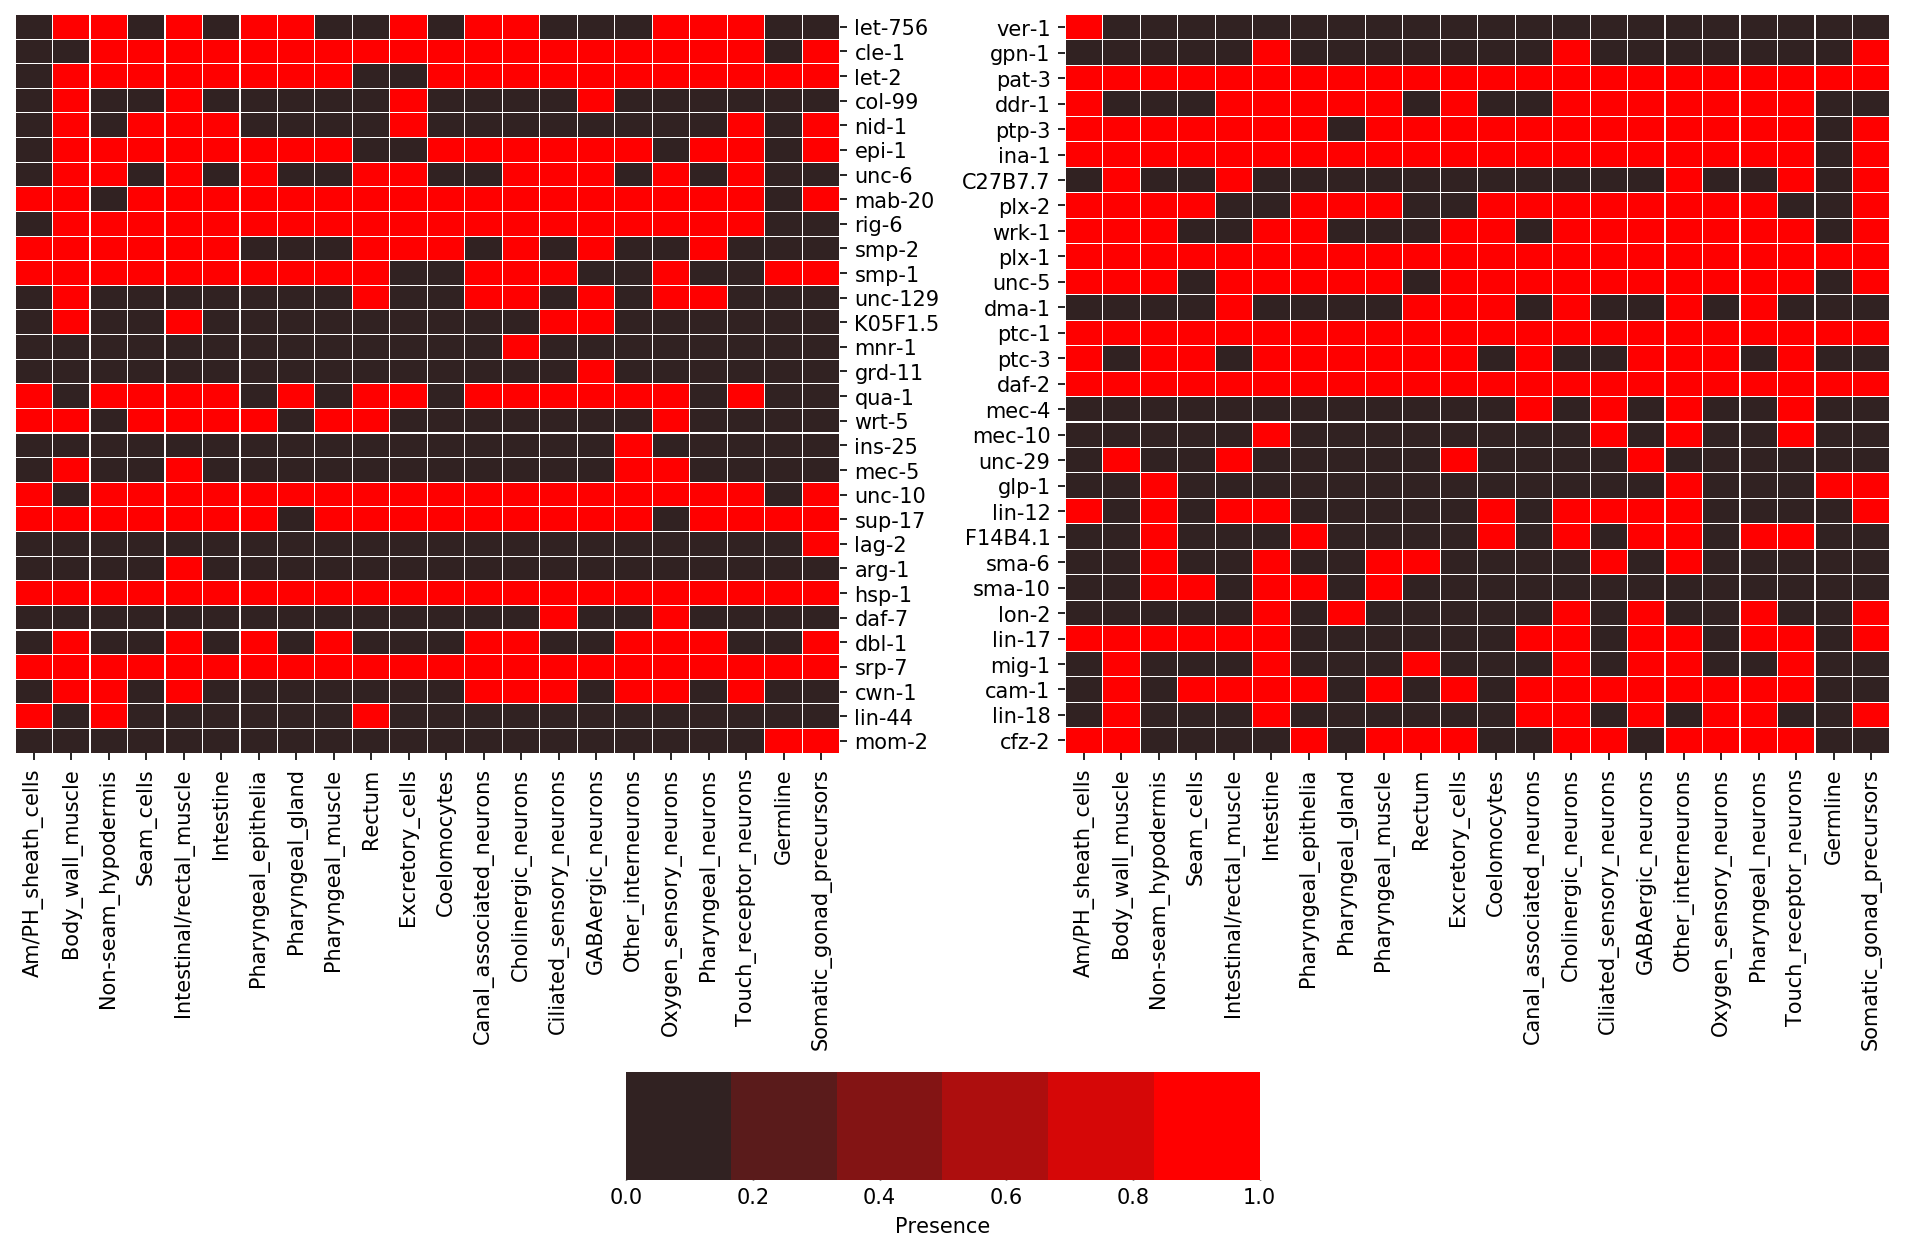

In [32]:
my_dpi = 150
fig, axn = plt.subplots(figsize=(1920 / my_dpi, 1080 / my_dpi), dpi=my_dpi, ncols=2, nrows=1)

cbar_ax = fig.add_axes([.33, -.1, .33, .1]) # x, y, x_lenght, y_lenght  
cbar_ax.tick_params(axis=u'both', which=u'both', length=0.2)
ticklabs = cbar_ax.get_yticklabels()
cbar_ax.set_yticklabels(ticklabs, fontsize = 24)    #labels size of color bar

plot_labels = ['Ligand', 'Receptor']
for i, ax in enumerate(axn.flat):
    title = plot_labels[i]
    df = interaction_space.modified_rnaseq.loc[lr_pairs.sort_values(['LR Function', 'index'] \
                                                                   )['{}_WB'.format(title)].drop_duplicates().values,
                                               cell_labels]

    sns.heatmap(df, 
                ax=ax,
                cbar=(i == 0),
                cbar_ax=None if i else cbar_ax,
                cbar_kws={'label': 'Presence', 'orientation': 'horizontal'},
                cmap=sns.dark_palette('red'),
                linewidths=0.05
               )
    
    ax.set_ylabel('')
    ax.tick_params(axis=u'y', which=u'both',
                   right=(i == 0),
                   left=(i == 1),
                   labelright=(i == 0),
                   labelleft=(i == 1),
                   rotation=0
                  )
    y_labels = [genes_dict[t.get_text()] for t in ax.yaxis.get_majorticklabels()]
    ax.set_yticklabels(labels=y_labels, rotation=0)
plt.tight_layout()

plt.savefig(files['output_folder'] + 'LR-Production-GA-Selected-Pairs.svg',
            dpi=300,
            bbox_inches='tight')

### Compute Correlation

**Spearman**

In [33]:
get_correlation(distance_mineuclidean.loc[included_cells, included_cells],
                interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells])

SpearmanrResult(correlation=-0.6333657309057459, pvalue=2.6294765000591562e-27)

**Pearson**

In [34]:
get_correlation(distance_mineuclidean.loc[included_cells, included_cells],
                interaction_space.interaction_elements['cci_matrix'].loc[included_cells, included_cells],
                corr_type='pearson'
               )

(-0.47138766914872937, 3.5139330336700037e-14)